In [23]:
!pip install split_folders

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import logging
import os
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display, HTML, Javascript
from sklearn import preprocessing
import numpy as np
import sys
import warnings
warnings.filterwarnings("ignore", message="Your PyDataset")
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')
warnings.filterwarnings("ignore")
# Define o nível de log da Tensorflow para 3 e ignora os demais níveis
logging.disable(logging.WARNING)
# 0 (INFO), 1 (WARNING), 2 (ERROR), 3 (FATAL)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import splitfolders

In [25]:
# montar drive
if not os.path.ismount('/content/drive'):
    print("Montando o Google Drive...")
    drive.mount('/content/drive')

In [26]:
folder_path = '/content/drive/MyDrive/PDI/ProjetoFinal'
dataset_path = folder_path + '/dataset'
train_path = dataset_path + '/train'
test_path = dataset_path + '/test'
val_path = dataset_path + '/val'
model_path = folder_path + '/model/trained_model.keras'
results_path = folder_path + '/results/'
checkpoint_path = folder_path + '/checkpoint/cp.weights.h5'
log_path = folder_path + '/log/logger.csv'
original_dataset = folder_path + '/original_dataset'
img_shape = (299, 299, 3)
metric = 'accuracy'
batch_size = 16
epoch_n = 150
seed = 2025

In [27]:
def split_folders(original_dataset,dataset_path):
  splitfolders.ratio(input=original_dataset, output=dataset_path, seed=seed, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)

In [28]:
def get_train_data(train_path, image_shape, batch_size, seed):
    # image aumentation e generation para imagens de treino para mais variação
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        vertical_flip=True, rescale=1./255, horizontal_flip=True, rotation_range=180, zoom_range=0.9, fill_mode = 'nearest', shear_range = 0.9, width_shift_range=0.2,
        height_shift_range=0.2)
    train_images = image_generator.flow_from_directory(
        train_path, target_size=image_shape[:2], batch_size=batch_size, class_mode='binary', shuffle=True, seed=seed)
    return train_images

In [29]:
def get_validation_data(val_path, image_shape, batch_size, seed):
    # normalização nas imagens de validação
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)
    validation_images = image_generator.flow_from_directory(
        val_path, target_size=image_shape[:2], batch_size=batch_size, class_mode='binary', shuffle=True, seed=seed)
    return validation_images


In [30]:
def get_test_data(test_path, image_shape, batch_size):
    # normalização nas imagens de validação
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)
    test_images = image_generator.flow_from_directory(
        test_path, target_size=image_shape[:2], batch_size=batch_size, class_mode='binary', shuffle=False)
    return test_images

In [31]:
def get_callback_functions(checkpoint_path, log_path):
    # callbacks necessarios
    # early stop
    # lower learning rate
    # checkpoint saving
    # logs
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', mode='auto', patience=10, verbose=1, restore_best_weights=True)
    llr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', factor=0.1, patience=5, verbose=1)
    checkpoint_save = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)
    logger = tf.keras.callbacks.CSVLogger(
        log_path, separator=',', append=False)

    return early_stop, llr, checkpoint_save, logger

In [32]:
def get_base_model(class_n, seed, image_shape):

    tf.random.set_seed(seed)

    base_model = tf.keras.applications.Xception(
        input_shape=image_shape, weights='imagenet', include_top=False)
    base_model.trainable = False

    input_layer = tf.keras.Input(shape=image_shape)
    x = base_model(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(64,kernel_regularizer=tf.keras.regularizers.L2(0.01), activation='relu')(x)

    x = tf.keras.layers.Dropout(0.5)(x)

    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(input_layer, output_layer)

    model.summary()

    return model

In [33]:
def compile_model(model, metric):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
    return model

In [34]:
def train_model(model, train_images, validation_images, epoch_n, checkpoint_path, callback_list):
    history = model.fit(train_images, epochs=epoch_n, verbose=1,
                        validation_data=validation_images, callbacks=callback_list)
    model.load_weights(checkpoint_path)
    return model, history

In [35]:
def model_saving(model, model_path):
    model.save(model_path)
    print(f'\nModelo salvo, {model_path}')

In [36]:
def plot_history(history, metric, results_path):
    # plota a evolução da acurácia e loss ao longo das épocas de treinamento
    plt.figure(1)
    # accuracy
    plt.subplot(211)
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Acurácia do Modelo')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend(['Treinamento', 'Validação'], loc='lower right')
    # loss
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Perda do Modelo')
    plt.ylabel('Perda')
    plt.xlabel('Época')
    plt.legend(['Treinamento', 'Validação'], loc='upper right')
    plt.tight_layout()
    plt.savefig(results_path+'Historico_Treinamento', dpi=300)
    print(f'\nHistórico salvo na pasta: {results_path}\n')
    plt.show()

In [37]:
def load_trained_model(model_path):
    if not os.path.exists(model_path):
        print(f"arquivo não encontrado {model_path}")
        sys.exit("Execução interrompida")

    model = tf.keras.models.load_model(model_path)
    return model

In [38]:
def test_model(model, test_images):
    predictions = model.predict(test_images, verbose=2)

    predicted_labels = (predictions > 0.5).astype(int).flatten()

    return predicted_labels

In [39]:
def show_confusion_matrix(correct_labels, predicted_labels, class_names, results_path):
    con_matrix = confusion_matrix(correct_labels, predicted_labels)

    acuracy = accuracy_score(correct_labels, predicted_labels)*100

    plt.figure(figsize=(10, 8))
    sns.heatmap(con_matrix, annot=True, cmap='Blues', fmt='g')

    plt.xticks(np.arange(len(class_names))+0.5,
               class_names, rotation=0, ha='right')
    plt.yticks(np.arange(len(class_names))+0.5,
               class_names, rotation=0, va='center')
    plt.xlabel('Rótulos Previstos')
    plt.ylabel('Rótulos Reais')
    plt.title('Matriz de Confusão', fontsize=18, weight='bold', x=0.5, y=1.05)
    plt.suptitle(
        f'Acurácia do Modelo: {acuracy:.2f}%', fontsize=14, x=0.435, y=0.92)
    plt.savefig(results_path+'Matriz_Confusao', dpi=300)
    print(f'\nMatriz salva na pasta: {results_path}\n')
    plt.show()

In [40]:
def plot_metric(correct_labels, predicted_labels, class_names, metric_names, results_path):
    report_dict = classification_report(correct_labels, predicted_labels,
                                        target_names=class_names, output_dict=True)

    metric_data = {
        class_name: metrics[metric_names]
        for class_name, metrics in report_dict.items()
        if class_name in class_names
    }
    sns.barplot(x=list(metric_data.keys()), y=list(metric_data.values()))
    plt.xlabel('Classes')
    plt.ylabel(metric_names.capitalize())
    plt.title(f'{metric_names.capitalize()} por Classe')
    plt.xticks(rotation=0)
    for index, value in enumerate(metric_data.values()):
        plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')
    plt.savefig(results_path+metric_names, dpi=300)
    print(f'\nMétrica salva na pasta: {results_path}\n')
    plt.show()

In [41]:
def train_pipeline():
    print("\n\n")
    train_images = get_train_data(train_path, img_shape, batch_size, seed)

    validation_images = get_validation_data(
        val_path, img_shape, batch_size, seed)

    clases_n = train_images.num_classes

    cnn_model = get_base_model(clases_n, seed, img_shape)

    compiled_model = compile_model(cnn_model, metric)

    early_stop, llr, checkpoint_save, logger = get_callback_functions(
        checkpoint_path, log_path)

    callback_list = [early_stop, llr, checkpoint_save, logger]

    trained_model, history = train_model(
        compiled_model, train_images, validation_images, epoch_n, checkpoint_path, callback_list)

    model_saving(trained_model, model_path)
    plot_history(history, metric, results_path)

In [42]:
def test_pipeline():
    print("\n\n")

    test_images = get_test_data(test_path, img_shape, batch_size)
    correct_labels = test_images.classes
    class_names = list(test_images.class_indices.keys())

    trained_model = load_trained_model(model_path)
    predicted_labels = test_model(trained_model, test_images)

    show_confusion_matrix(
        correct_labels,
        predicted_labels,
        class_names,
        results_path)

    plot_metric(
        correct_labels,
        predicted_labels,
        class_names,
        'precision',
        results_path)

    plot_metric(
        correct_labels,
        predicted_labels,
        class_names,
        'recall',
        results_path)

    plot_metric(
        correct_labels,
        predicted_labels,
        class_names,
        'f1-score',
        results_path)



Selecione uma opção:
1. Executar o pipeline de treinamento
2. Executar o pipeline de teste
3. Sair


Digite o número da sua escolha: 1



Found 224 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 2048)   │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,000,873 (80.11 MB)

 Trainable params: 135,297 (528.50 KB)

 Non-trainable params: 20,865,576 (79.60 MB)

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step - accuracy: 0.4847 - loss: 2.1069 - val_accuracy: 0.6429 - val_loss: 1.8979 - learning_rate: 1.0000e-04
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 66s 931ms/step - accuracy: 0.5599 - loss: 1.9605 - val_accuracy: 0.7143 - val_loss: 1.8394 - learning_rate: 1.0000e-04
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 827ms/step - accuracy: 0.5799 - loss: 1.9987 - val_accuracy: 0.7143 - val_loss: 1.7909 - learning_rate: 1.0000e-04
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 753ms/step - accuracy: 0.7354 - loss: 1.7504 - val_accuracy: 0.7143 - val_loss: 1.7451 - learning_rate: 1.0000e-04
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 805ms/step - accuracy: 0.7276 - loss: 1.7474 - val_accuracy: 0.7143 - val_loss: 1.7018 - learning_rate: 1.0000e-04
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 811ms/step - accuracy: 0.7821 - loss: 1.6786 - val_accuracy: 0.7143 - val_loss: 1.6653 - learning_rate: 1.0000e-04
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 944ms/step -

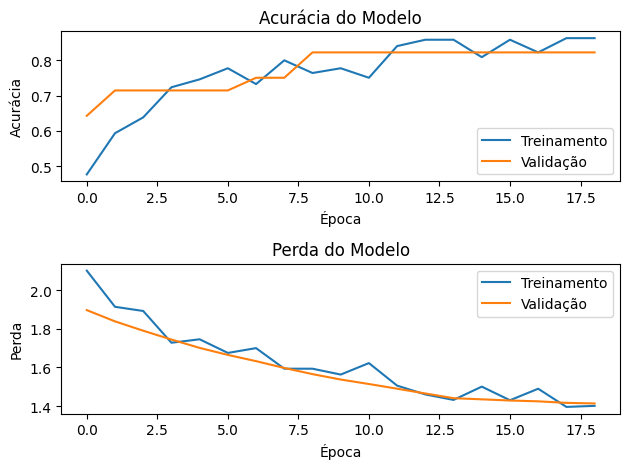



Selecione uma opção:
1. Executar o pipeline de treinamento
2. Executar o pipeline de teste
3. Sair


Digite o número da sua escolha: 2



Found 28 images belonging to 2 classes.
2/2 - 6s - 3s/step

Matriz salva na pasta: /content/drive/MyDrive/PDI/ProjetoFinal/results/



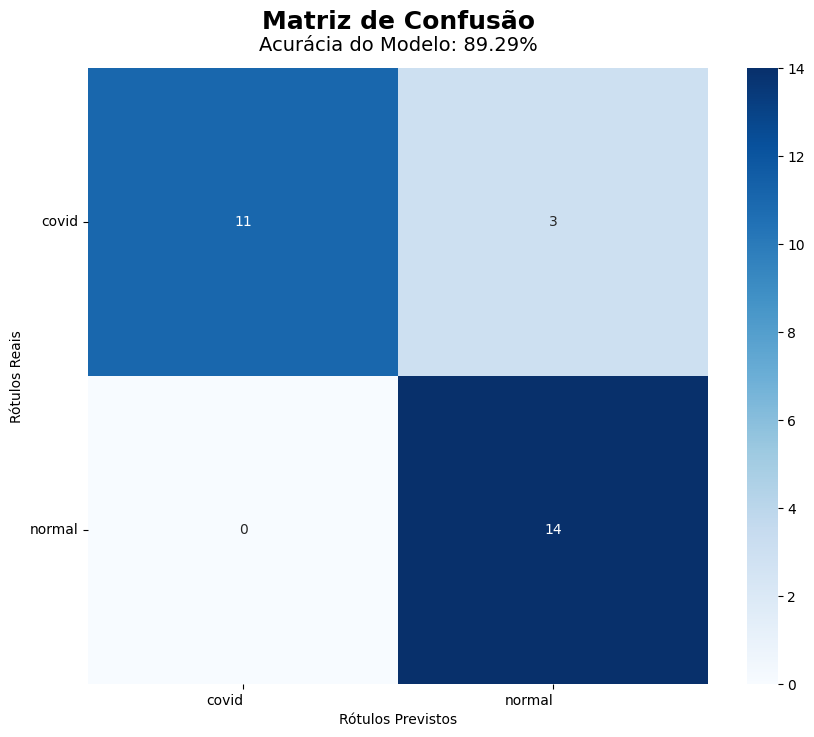


Métrica salva na pasta: /content/drive/MyDrive/PDI/ProjetoFinal/results/



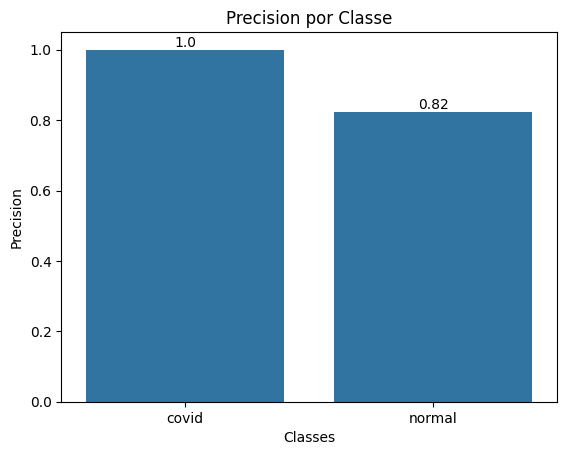


Métrica salva na pasta: /content/drive/MyDrive/PDI/ProjetoFinal/results/



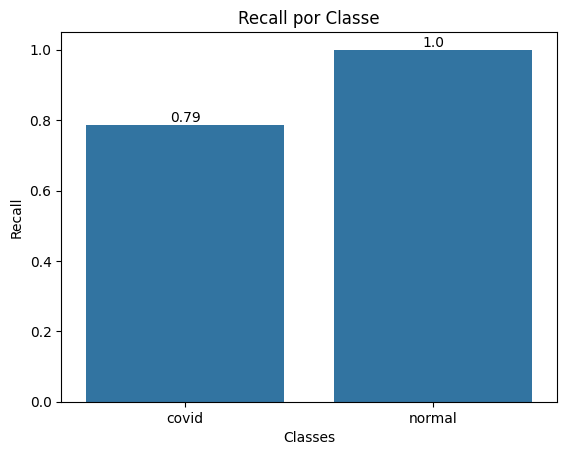


Métrica salva na pasta: /content/drive/MyDrive/PDI/ProjetoFinal/results/



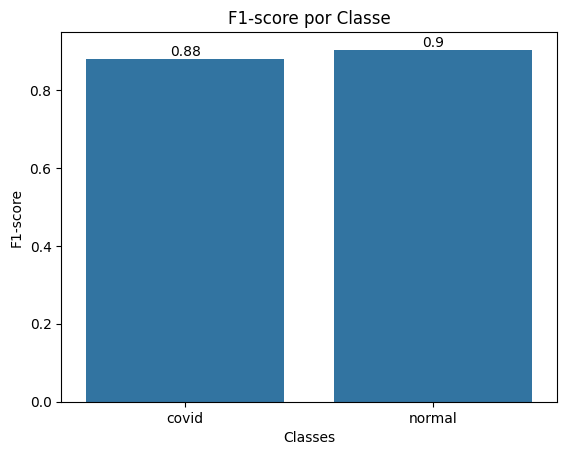



Selecione uma opção:
1. Executar o pipeline de treinamento
2. Executar o pipeline de teste
3. Sair


Digite o número da sua escolha: 3
Execução finalizada!


In [43]:
def menu():
    #split_folders(original_dataset,dataset_path)
    while True:
        print("\n")
        print("Selecione uma opção:")
        print("1. Executar o pipeline de treinamento")
        print("2. Executar o pipeline de teste")
        print("3. Sair")
        print("\n")

        escolha = input("Digite o número da sua escolha: ")

        if escolha == '1':
            train_pipeline()
        elif escolha == '2':
            test_pipeline()
        elif escolha == '3':
            print("Execução finalizada!")
            break
        else:
            print("Escolha inválida. Por favor, selecione uma opção válida.")


menu()
